<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/4.%20EDA/EAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LassoCV, ElasticNetCV

In [2]:
# Adjust the display settings to increase the width
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap DataFrame horizontally
pd.set_option('display.width', 240)  # Set the maximum width of the display

In [3]:
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation%20/clean_data.csv' -O clean_data.csv

# Load the downloaded CSV files into pandas DataFrames
data = pd.read_csv('clean_data.csv')

print(data.head())

--2024-04-27 20:01:01--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation%20/clean_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169365 (165K) [text/plain]
Saving to: ‘clean_data.csv’

clean_data.csv      100%[===================>] 165.40K  --.-KB/s    in 0.02s   

2024-04-27 20:01:02 (6.56 MB/s) - ‘clean_data.csv’ saved [169365/169365]

     Age   BMI  Sex  Height  Weight  Length_of_Stay  Alvarado_Score  Paedriatic_Appendicitis_Score  Appendix_on_US  Appendix_Diameter  Migratory_Pain  Lower_Right_Abd_Pain  Contralateral_Rebound_Tenderness  Coughing_Pain  Nausea  Loss_of_Appetite  Body_Temperature  WBC_Count  Neutrophil_Percentage  Segmented_Neutrophils  Neutrophilia  RBC_Count  Hemoglobin   RDW  Thrombocyte_Count  Ke

In [4]:
X = data.drop('Diagnosis', axis=1)  # Features
y = data['Diagnosis']               # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**OUTLIER DETECTION**

Outlier detection is a crucial step in EDA as outliers can significantly skew the results of an analysis and affect the performance of predictive models. An outlier is an observation that lies an abnormal distance from other values in a random sample from a population. Identifying outliers involves statistical tests or visualization, such as box plots, which graphically depict groups of numerical data through their quartiles. Box plots are particularly useful for highlighting when a feature has a number of outlier values.

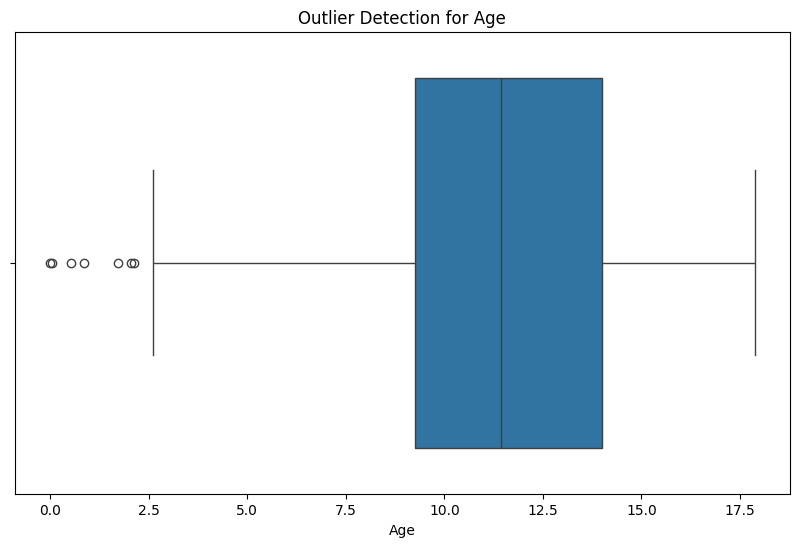

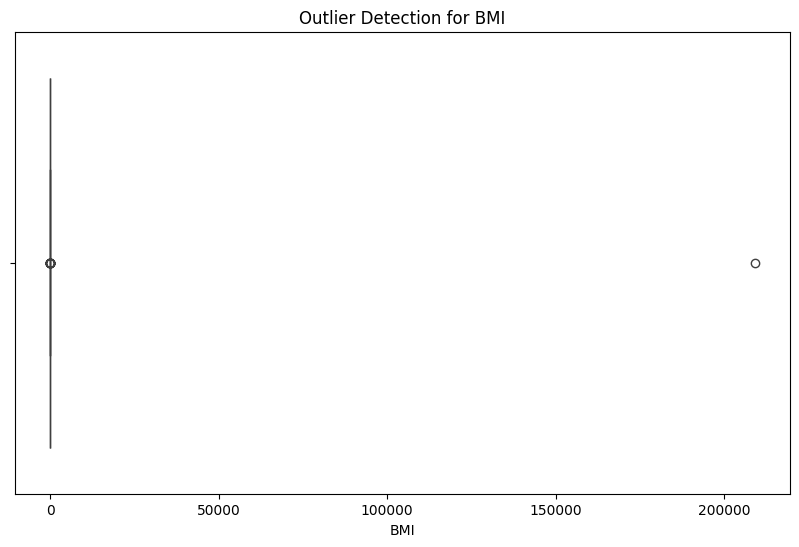

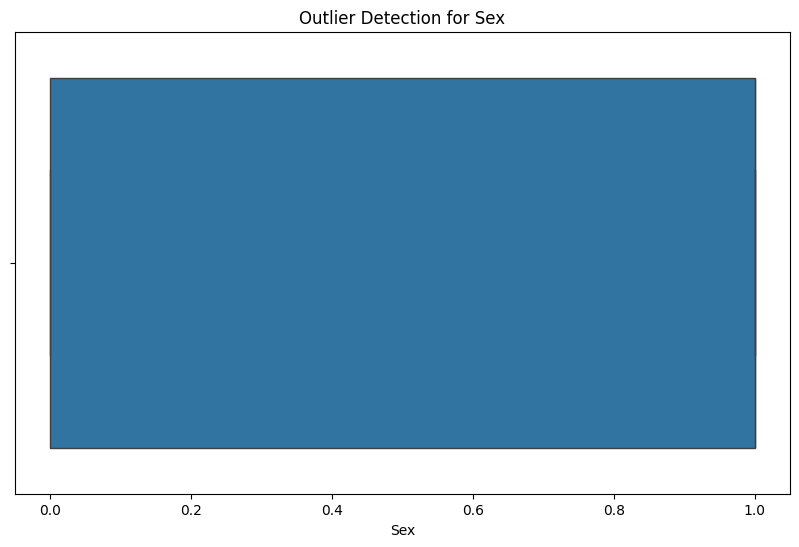

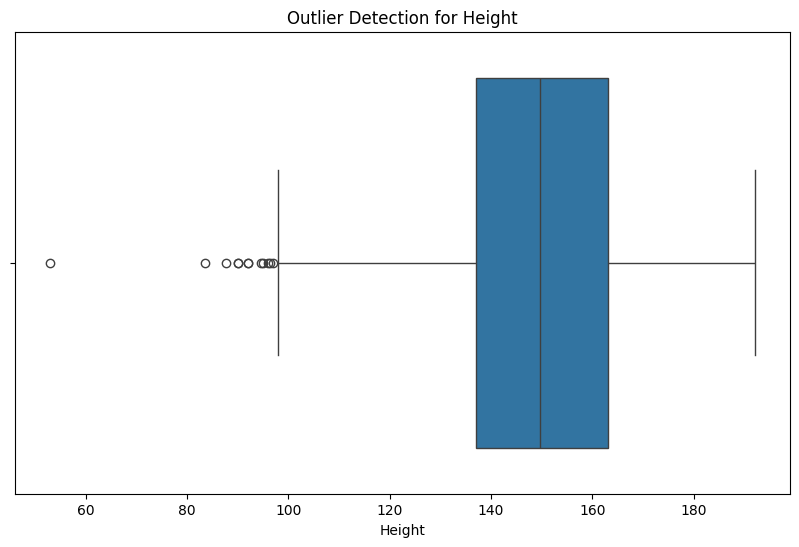

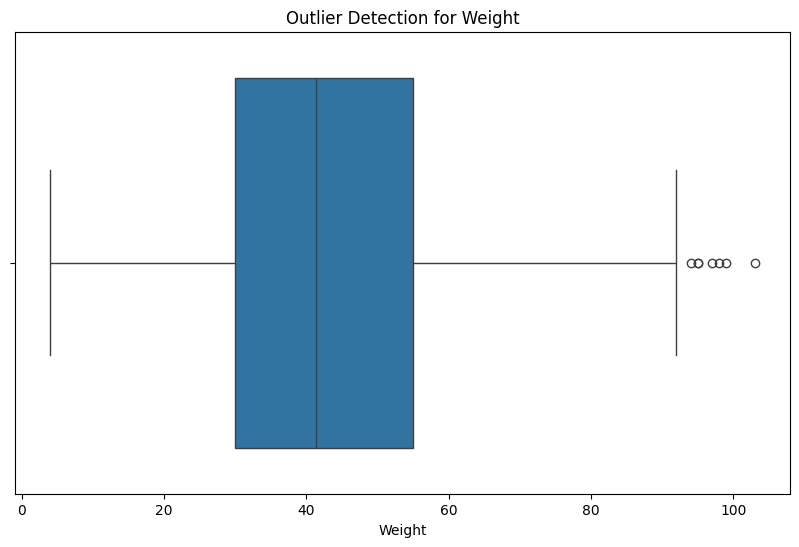

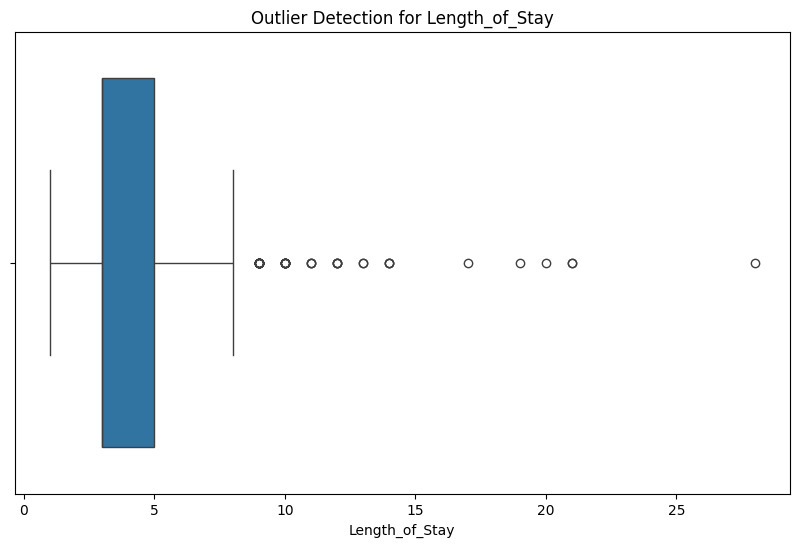

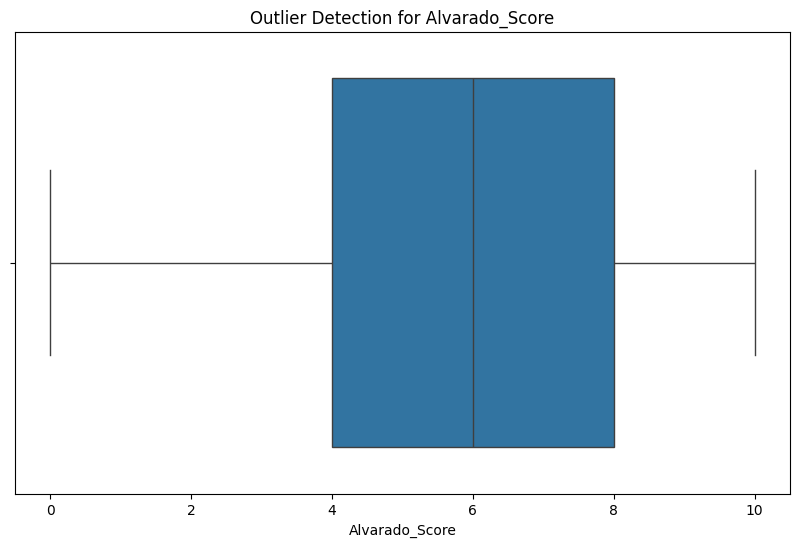

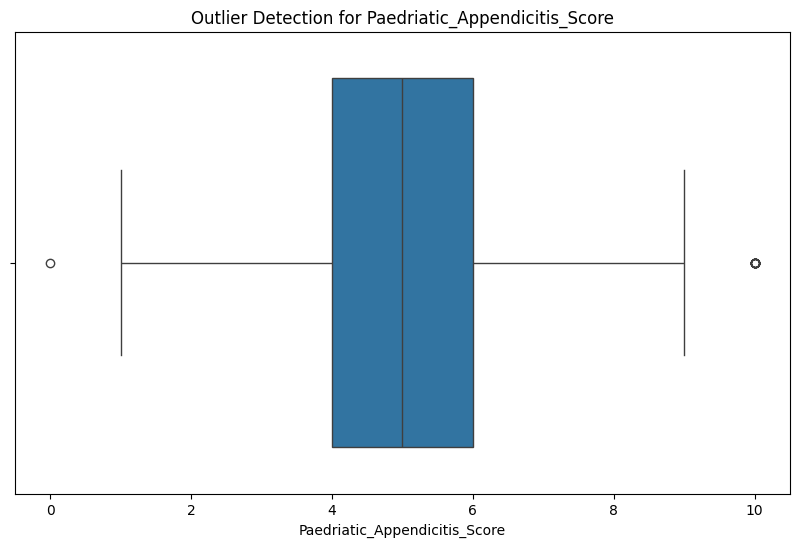

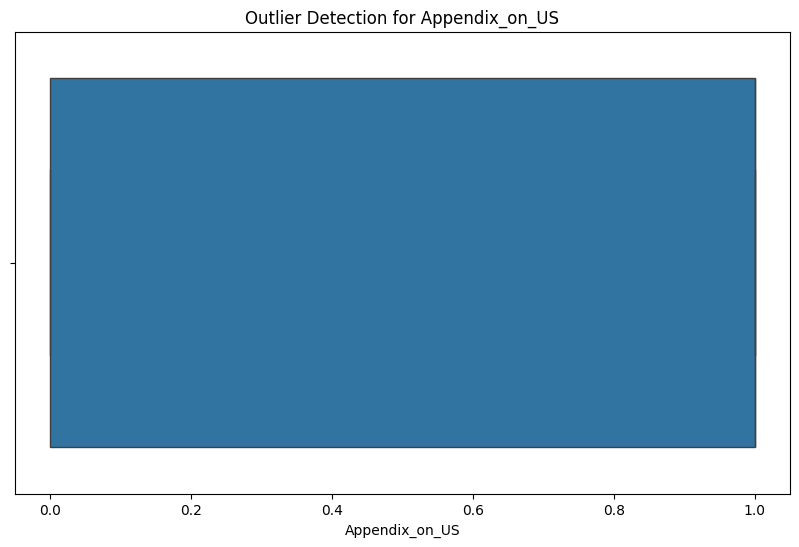

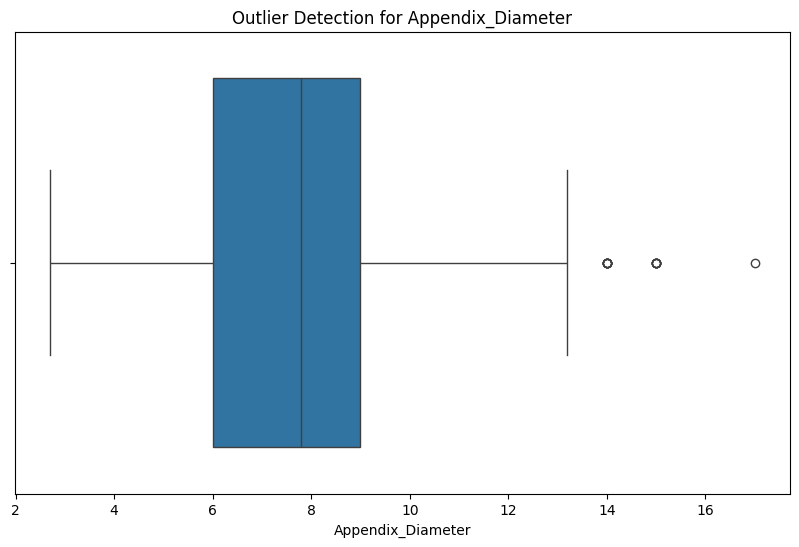

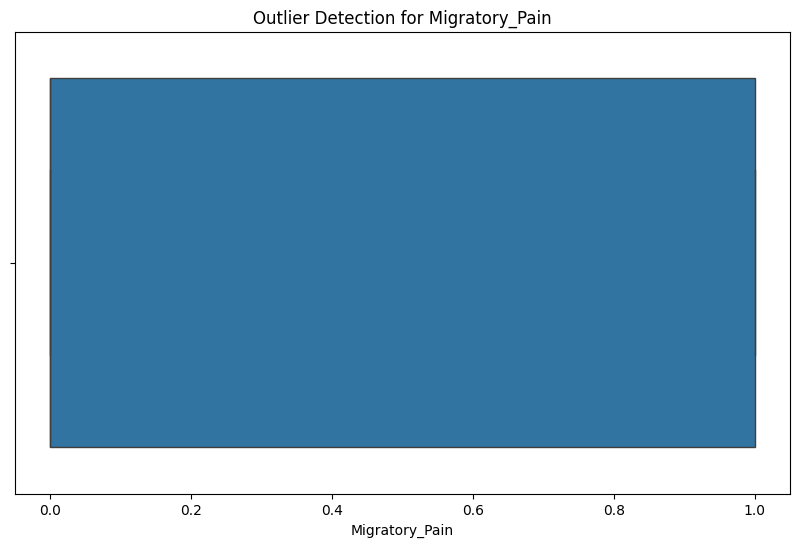

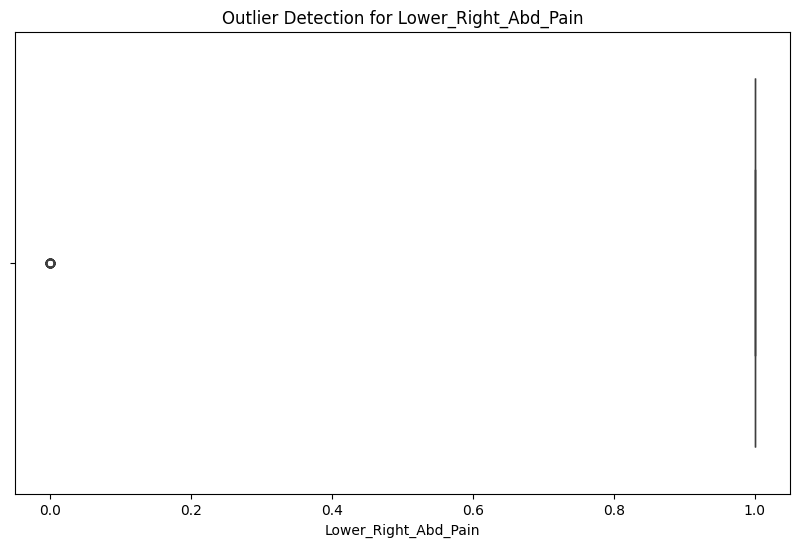

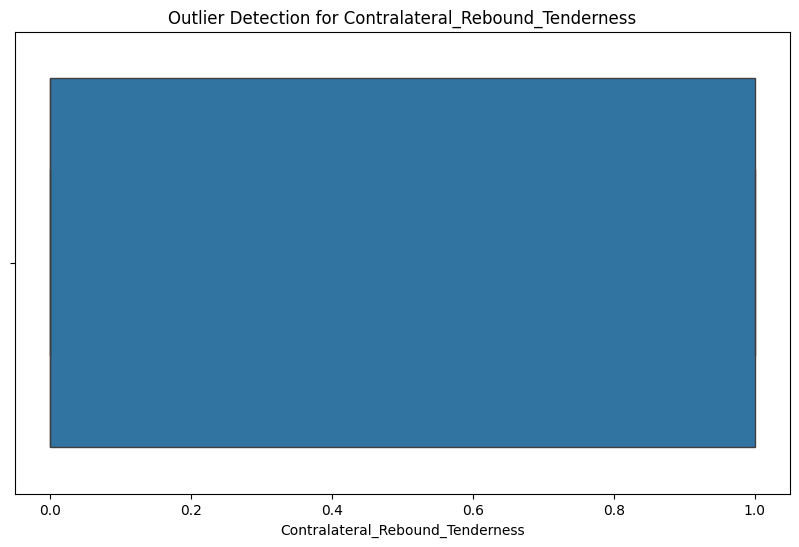

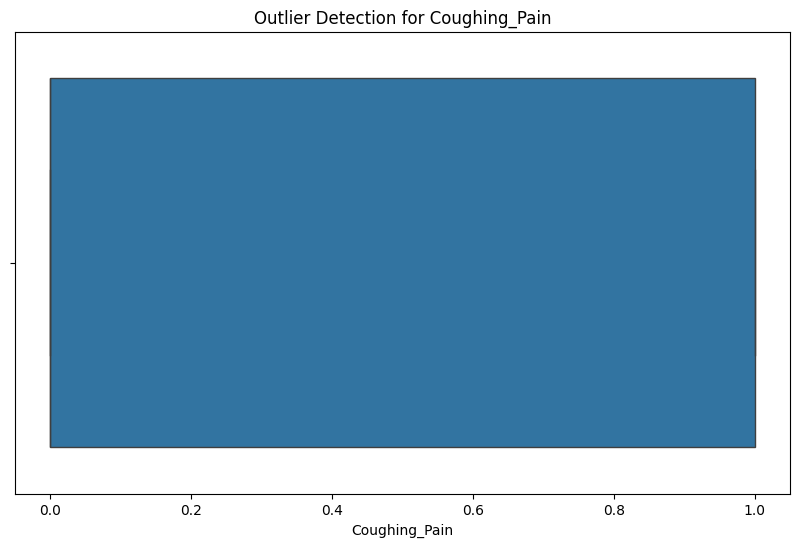

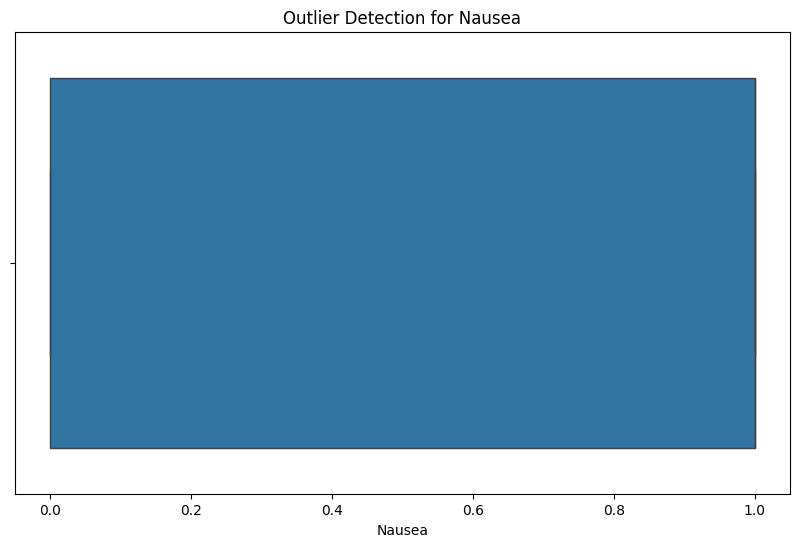

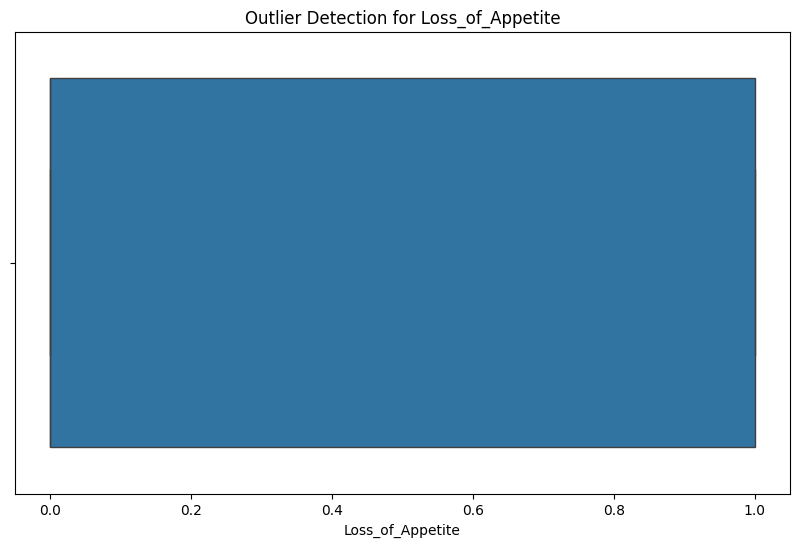

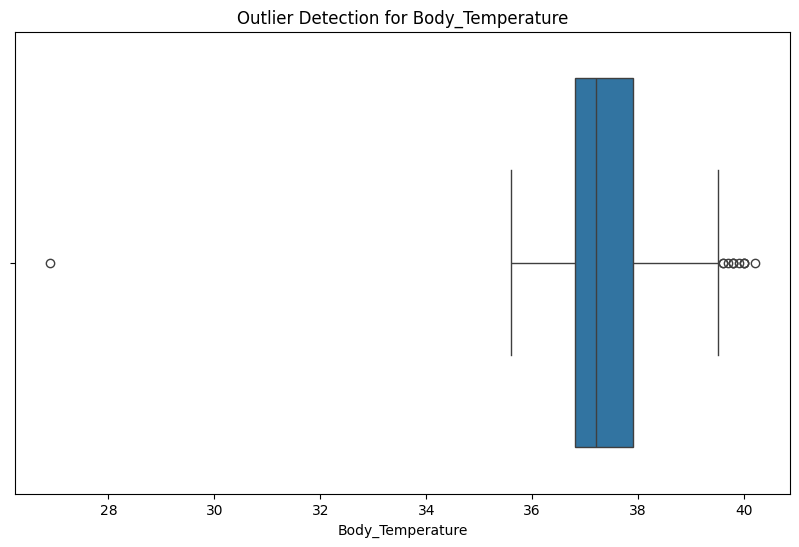

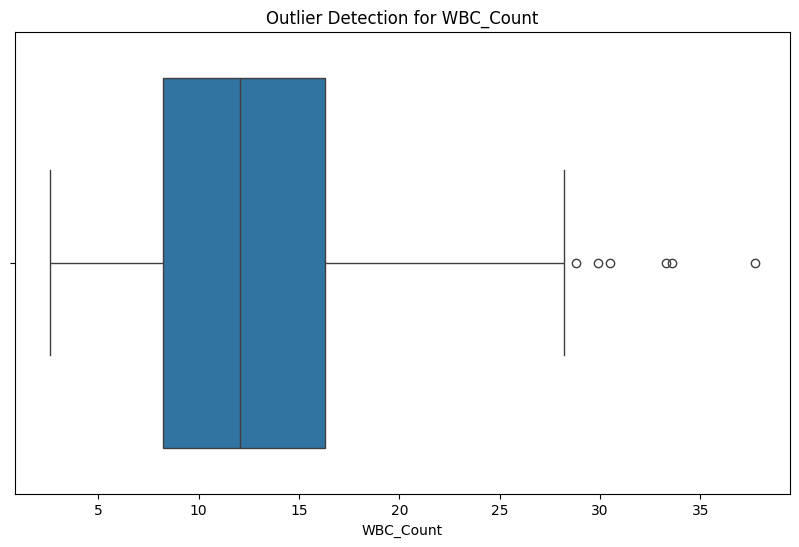

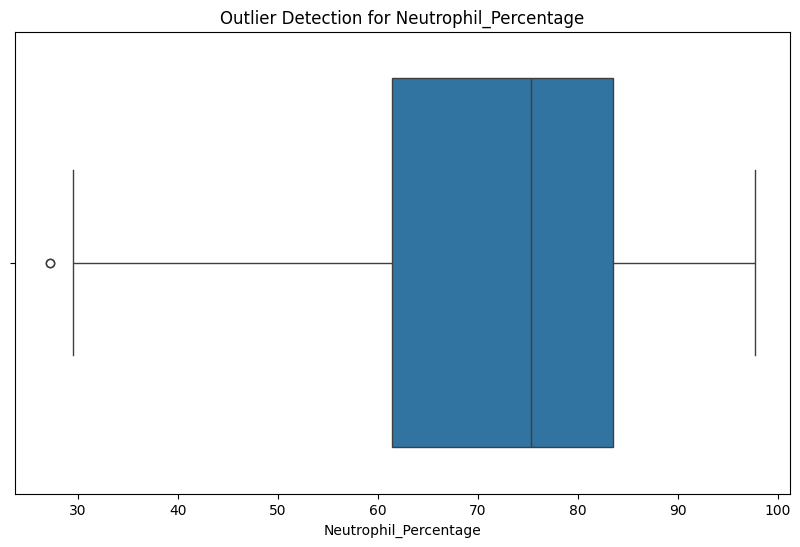

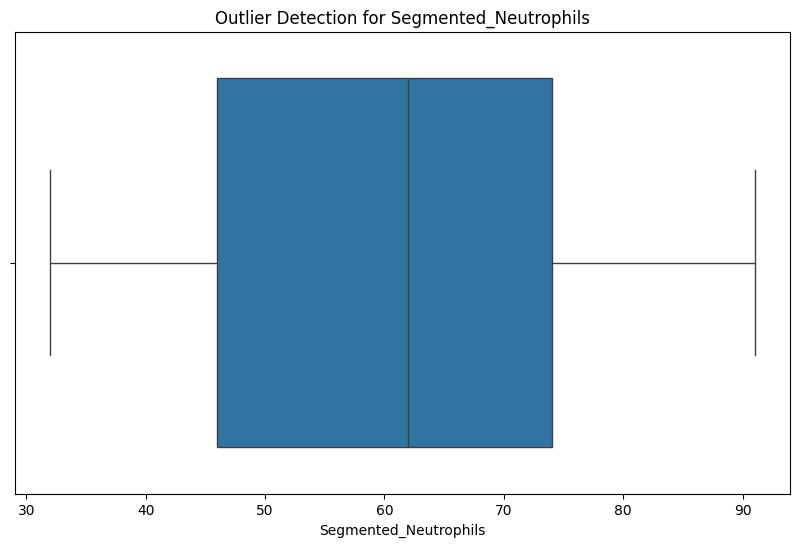

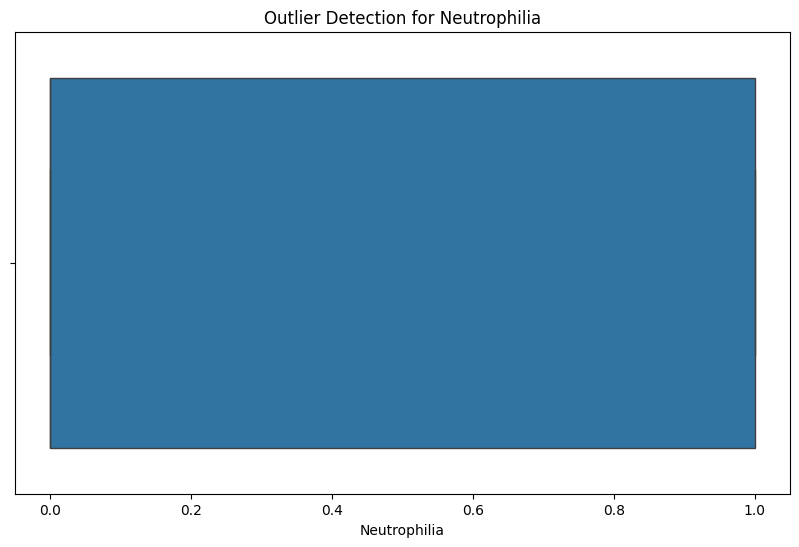

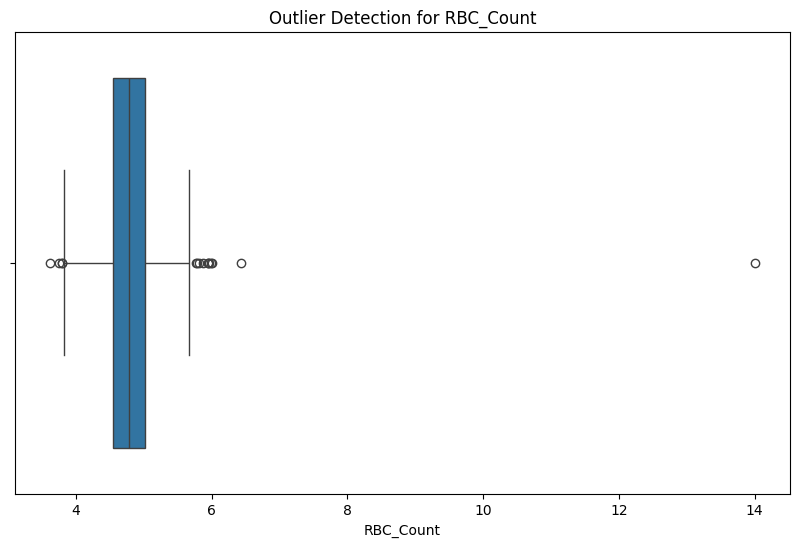

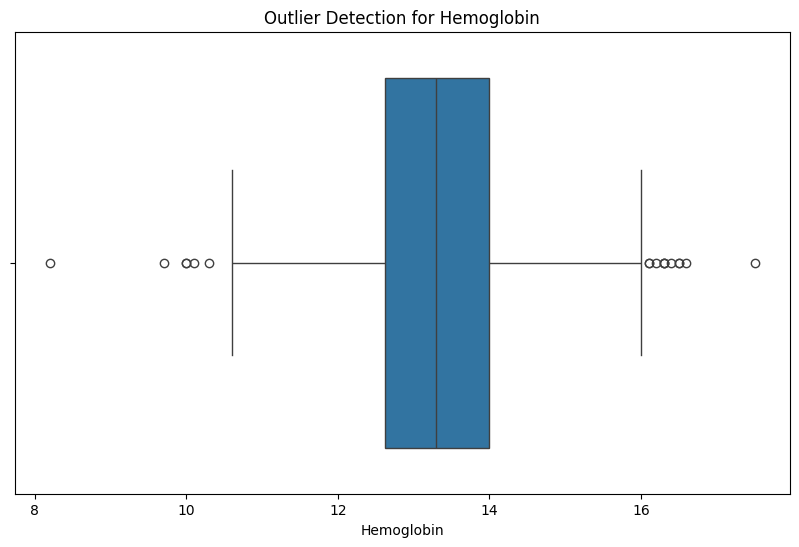

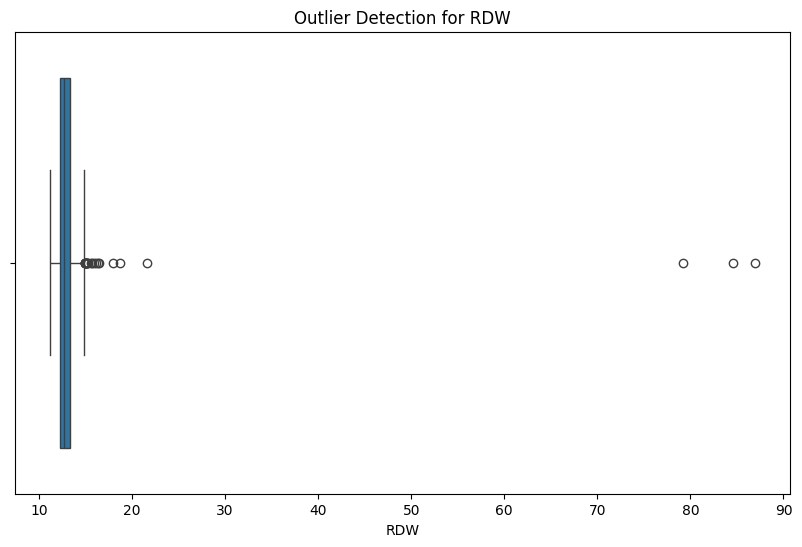

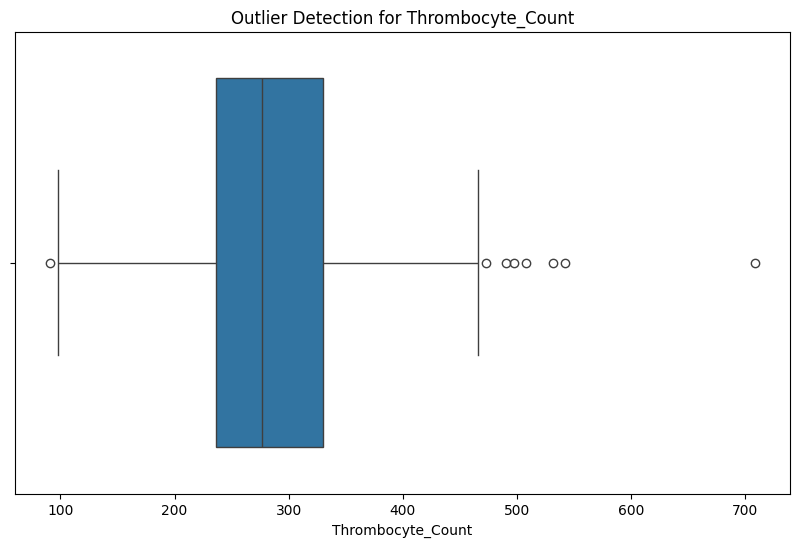

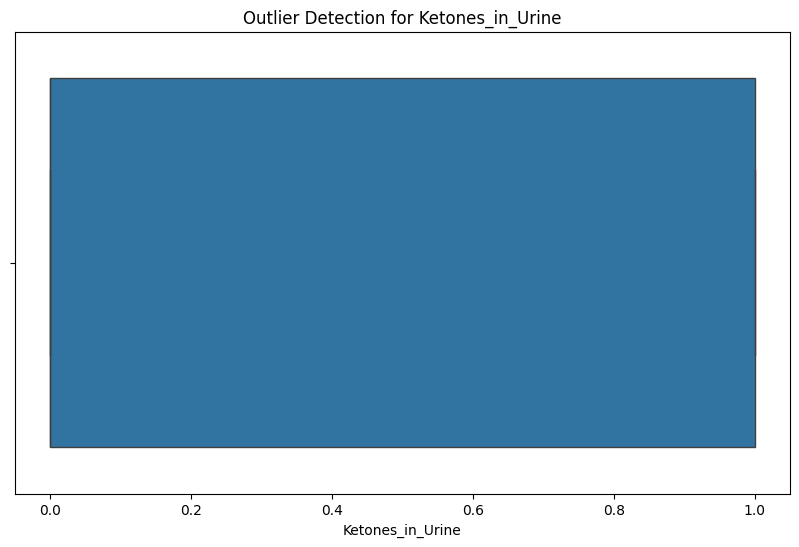

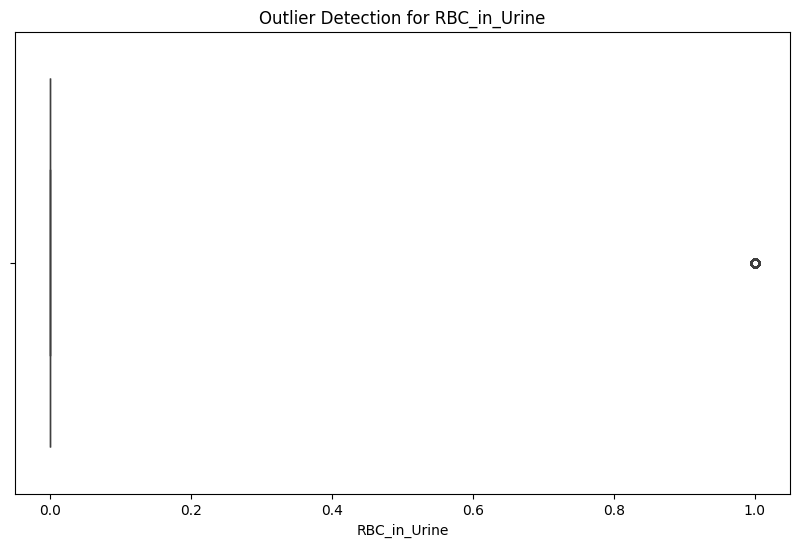

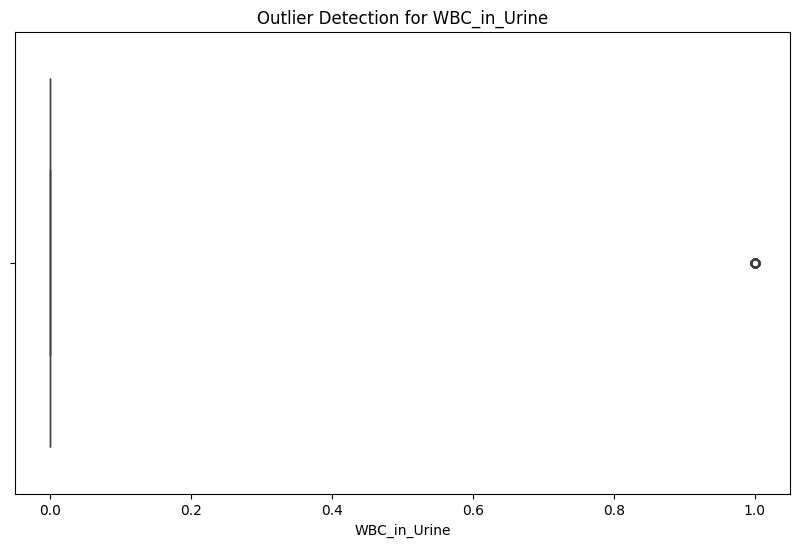

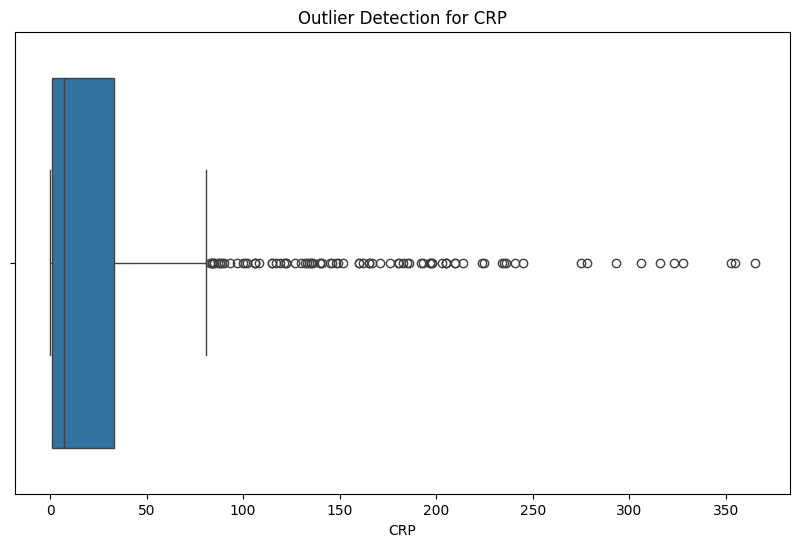

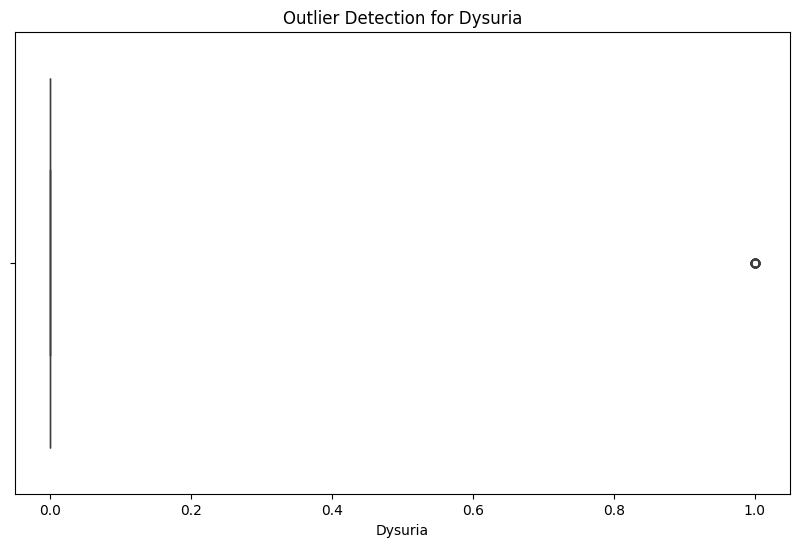

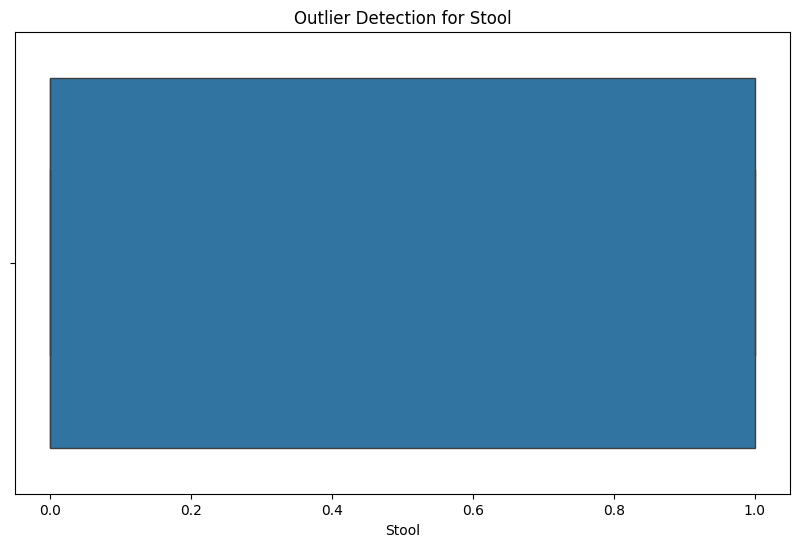

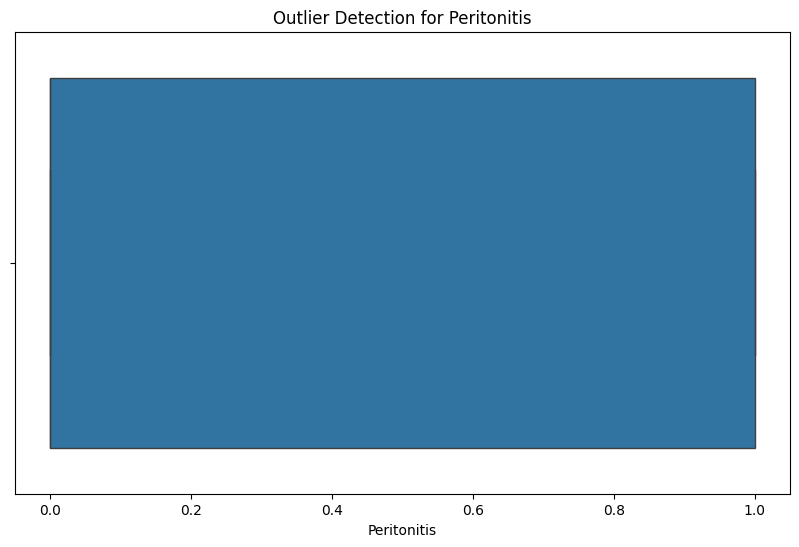

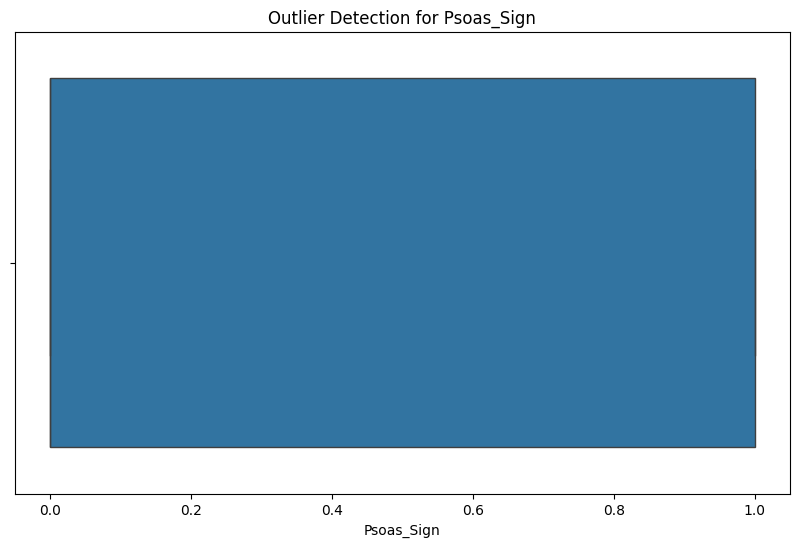

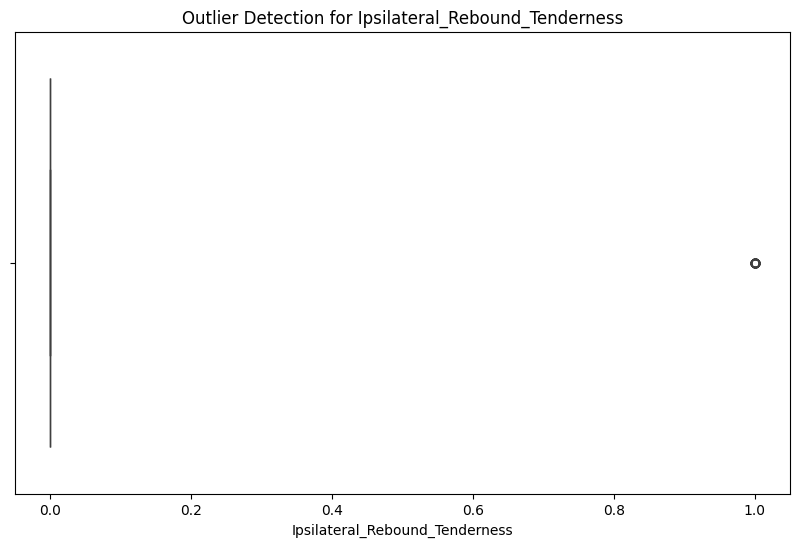

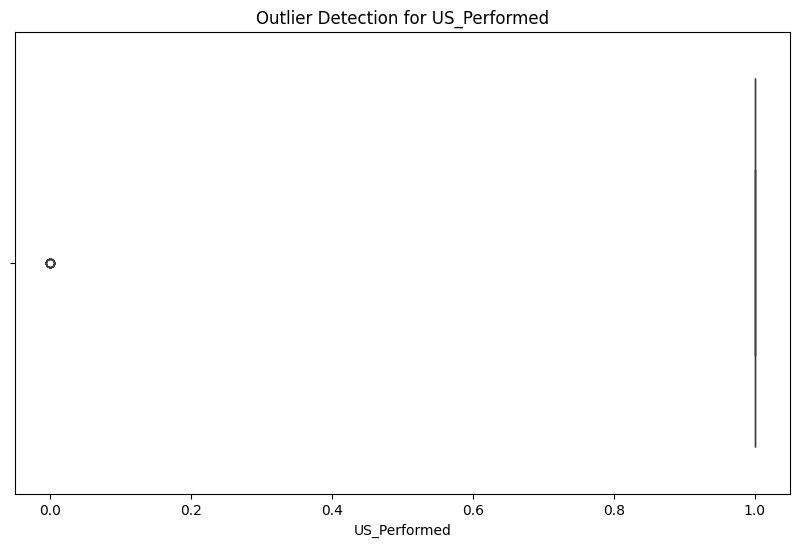

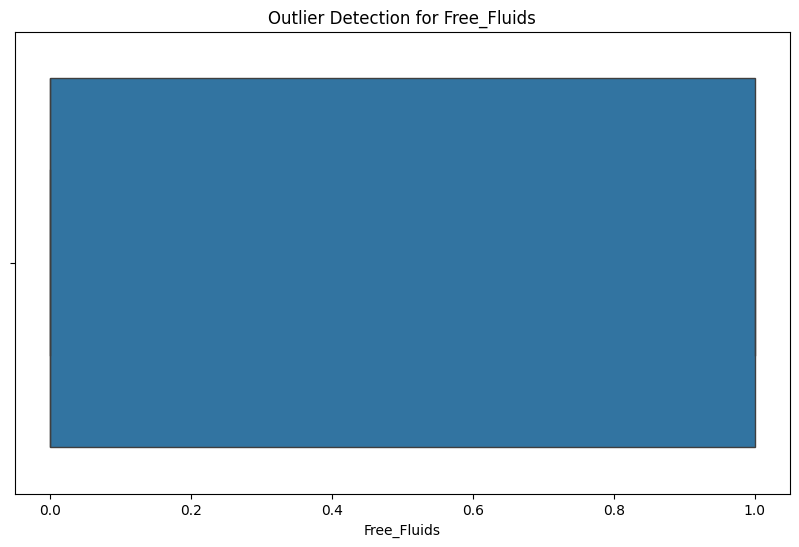

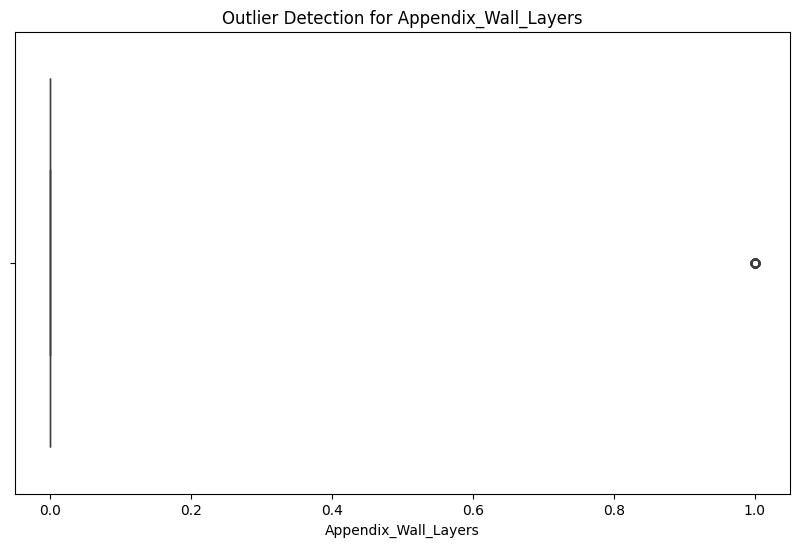

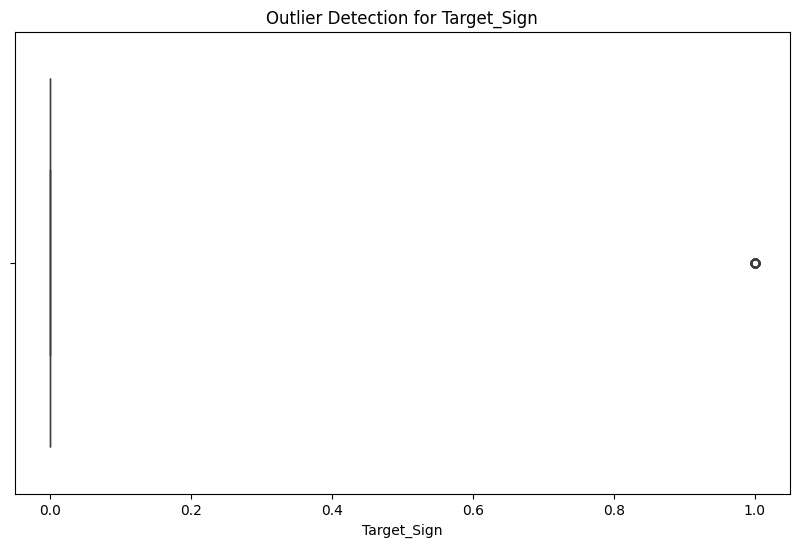

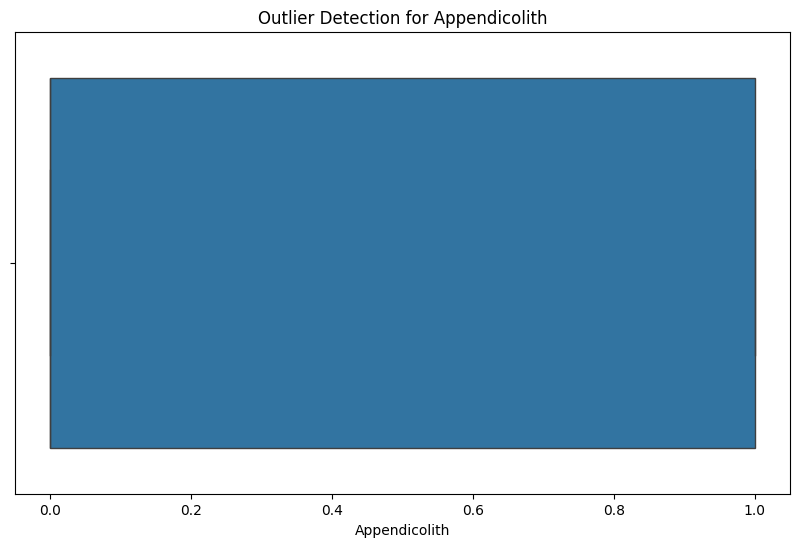

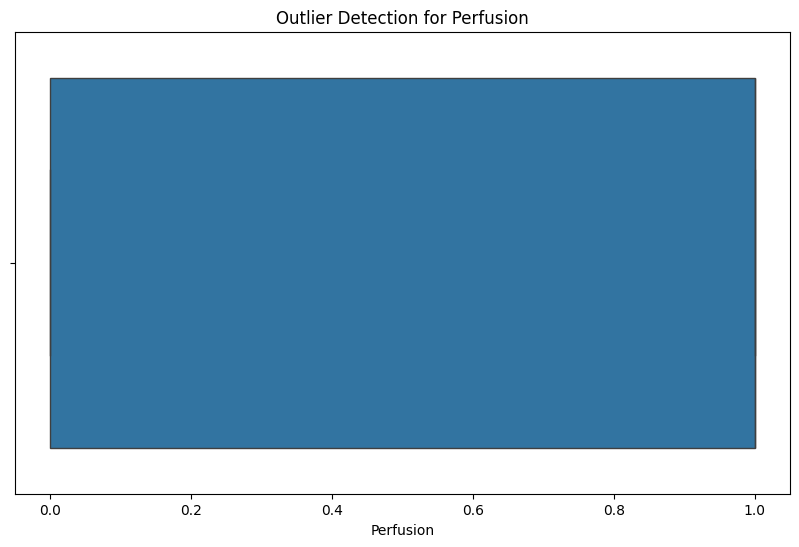

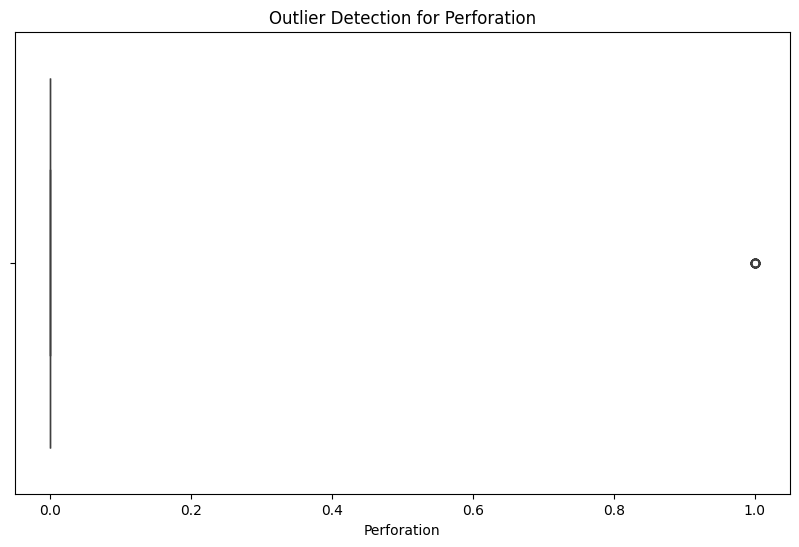

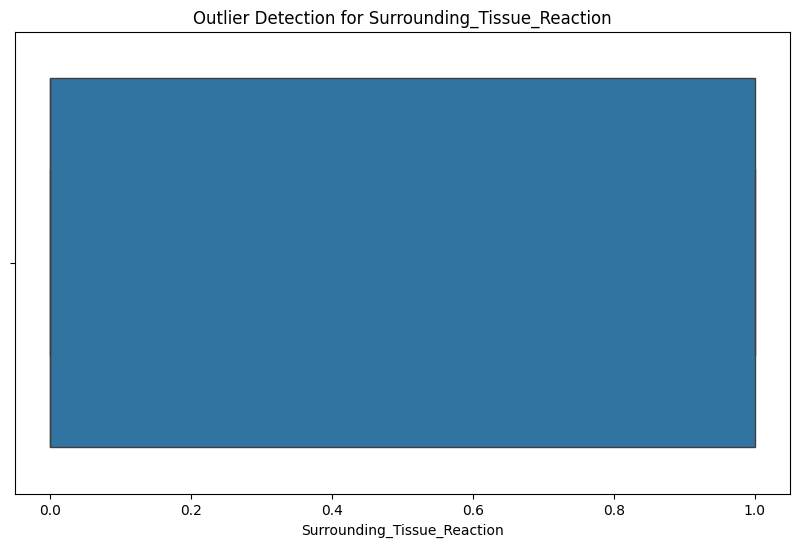

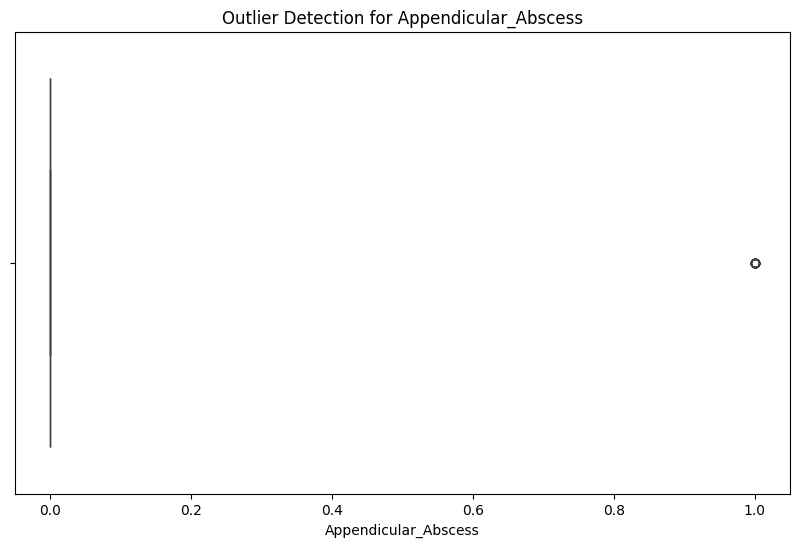

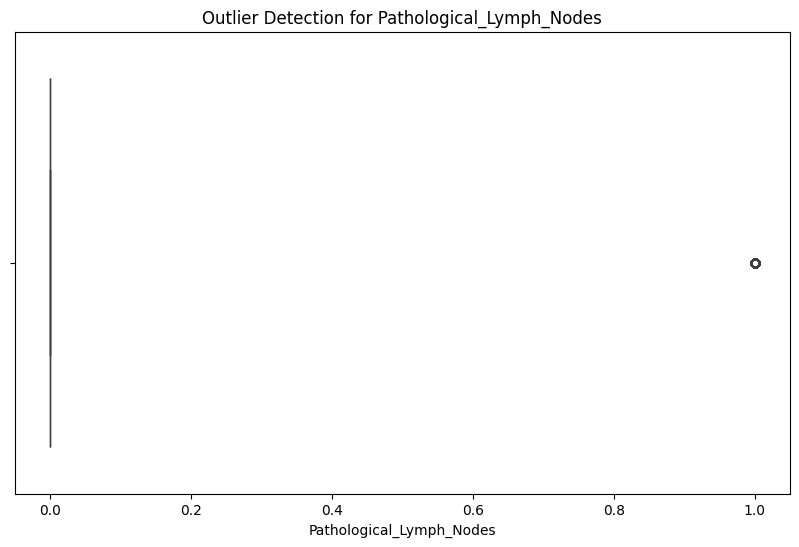

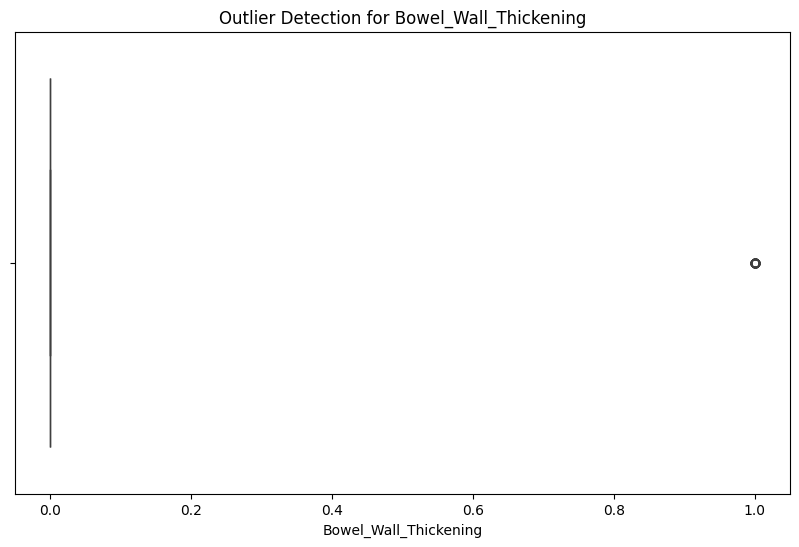

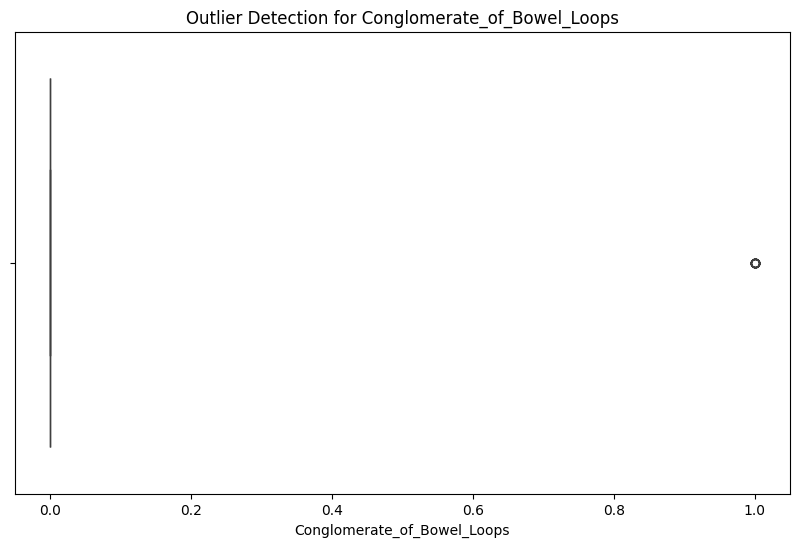

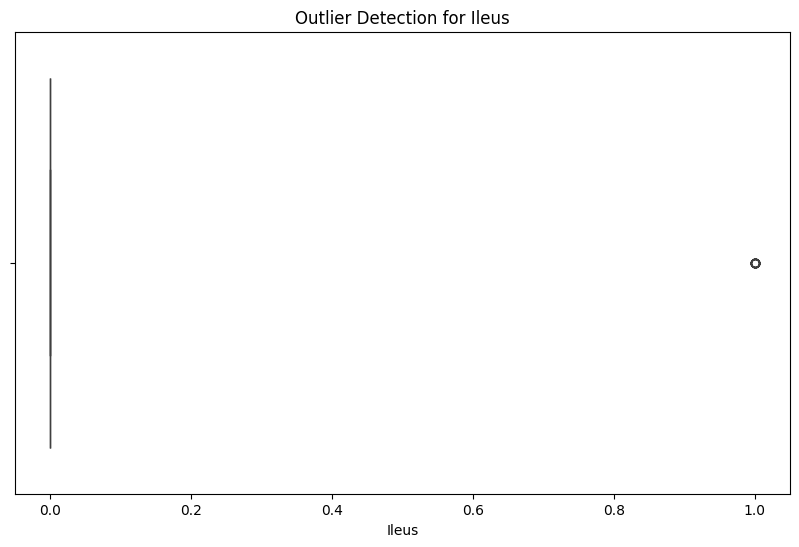

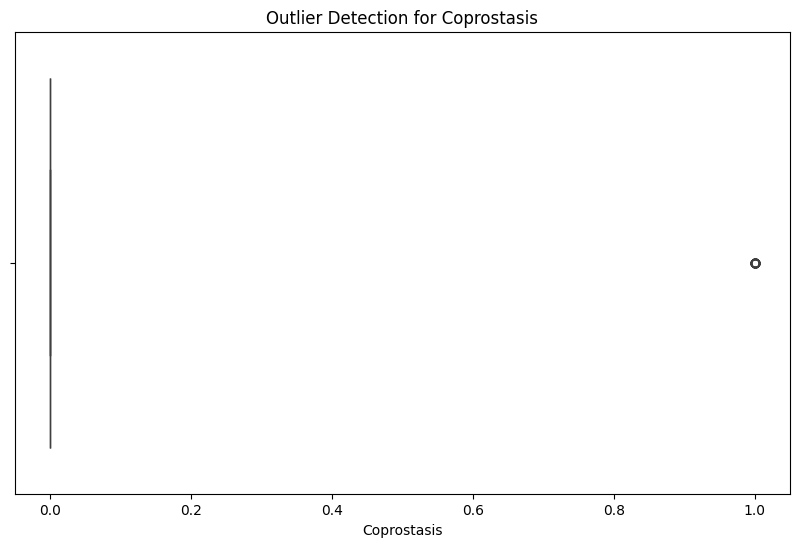

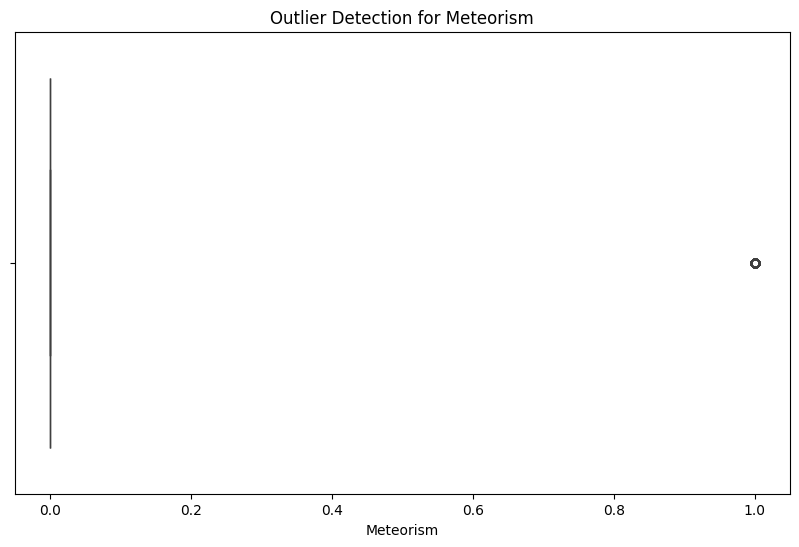

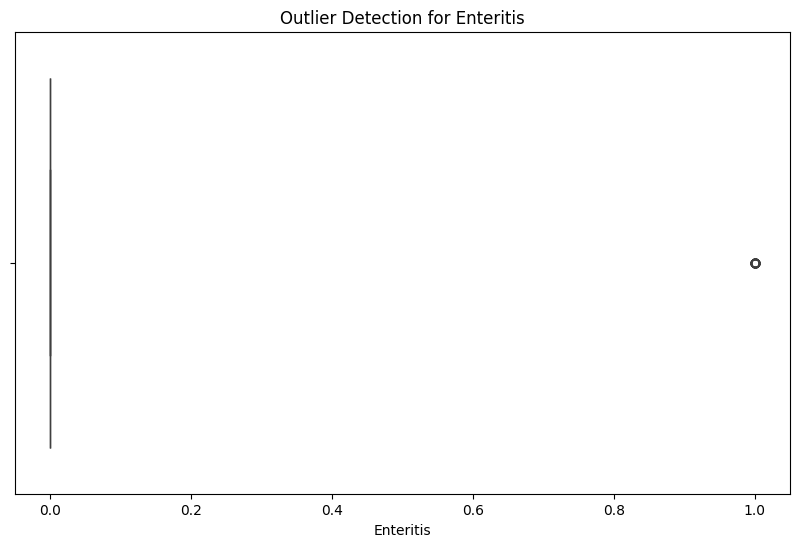

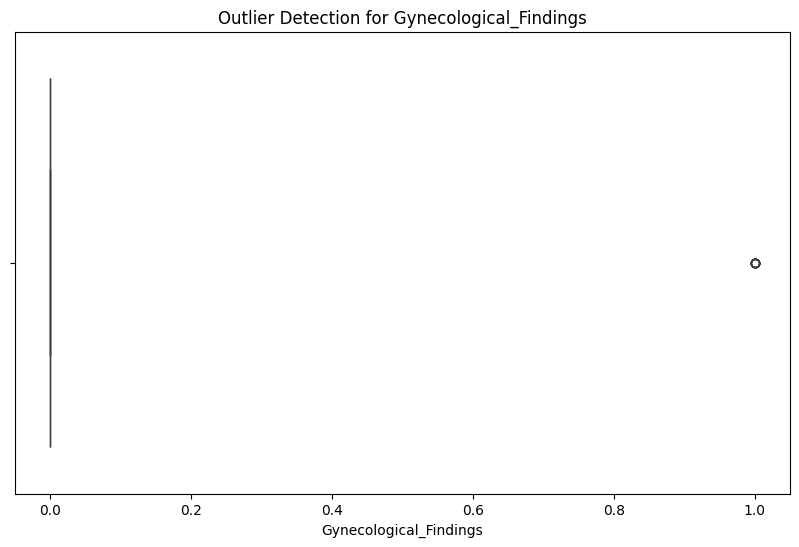

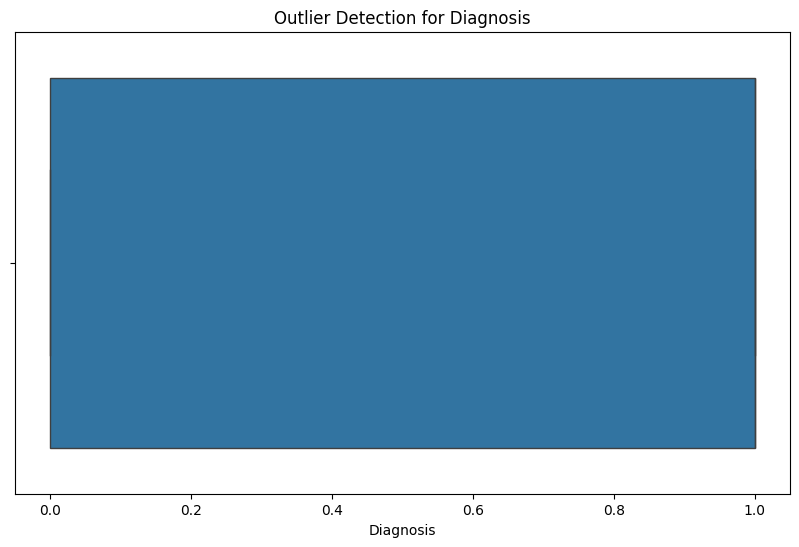

In [5]:
# We will create a loop to generate box plots for all numeric features in the dataset for outlier detection

# Box plots for outlier detection
for feature in data.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x=feature)
    plt.title(f'Outlier Detection for {feature}')
    plt.show()

**AVERAGE FEATURE Feature Correlation**

This analysis and plot provides insight into the interdependencies among features in the dataset. Features with very high average correlations might be candidates for further examination to see if any can be removed to reduce multicollinearity, especially for the use of linear models or other algorithms that assume feature independence.

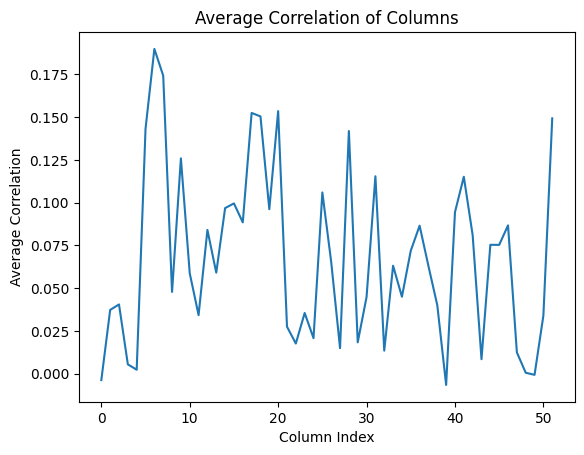

In [6]:
correlation_columns = data.corr()
mean_correlation_columns = correlation_columns.mean(axis=1)

plt.plot(range(len(mean_correlation_columns)), mean_correlation_columns)
plt.xlabel('Column Index')
plt.ylabel('Average Correlation')
plt.title('Average Correlation of Columns')
plt.show()

The plot reveals that while most features have relatively low average correlations with each other, a few features stand out with higher average correlations, peaking at certain column indices. This may indicate redundancy among some of the features, which could be further investigated for feature selection, especially if using modeling techniques that assume feature independence.

**AVERAGE CORRELATION BETWEEN ROWS**

Transposing the Data is done to focus on the relationships between features (variables) across all observations rather than between observations themselves.
Correlation Matrix helps identify how features are associated with one another. For instance, highly correlated features might be redundant, or they might indicate a strong dependency that could be exploited in feature engineering or model interpretation. By transposing, what were originally individual data points within features become separate features themselves. Analyzing correlations in this transposed view helps understand the degree to which these new 'features' move together, which might be important for understanding grouped behaviors in the data.

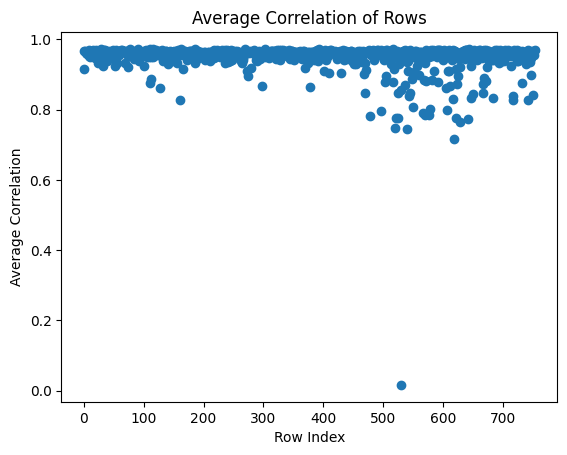

In [7]:
# Transpose the data to analyze properties or relationships between what were originally columns.
data_transposed = data.transpose()

# In the transposed dataframe, what were originally rows (samples) are now treated as features (variables), and what were originally columns (features) are now treated as samples.
# This allows us to analyze correlations between original features across all samples.
correlation_rows = data_transposed.corr()

# Calculate the mean correlation for each row (originally a feature in 'data') with all other rows.
# 'axis=1' specifies that the mean should be computed horizontally across columns, thus providing the average correlation of each feature with every other feature.
mean_correlation_rows = correlation_rows.mean(axis=1)

# Plotting the average correlation of each row with all other rows.
# 'range(len(mean_correlation_rows))' generates a sequence of numbers from 0 to the number of rows minus one, which serves as the x-axis.
# 'mean_correlation_rows' contains the average correlation values for each row and is used as the y-axis.
plt.scatter(range(len(mean_correlation_rows)), mean_correlation_rows)
plt.xlabel('Row Index')  # Label for the x-axis indicating these are indices of the original features.
plt.ylabel('Average Correlation')  # Label for the y-axis indicating these are average correlation values.
plt.title('Average Correlation of Rows')  # Title of the plot.
plt.show()  # Display the plot.

The scatter plot shows a distribution of average correlations, with each dot representing the mean correlation of one feature (row post-transposition) with all other features. If many points are clustered near a high correlation value (close to 1.0), it could imply that many features are highly interdependent, which might affect certain types of models that assume feature independence. Conversely, if the points are spread out or lower, it indicates varying degrees of relationships, with some features being more independent of others.

**PRINCIPAL COMPONENT ANALYSIS (PCA)**

PCA is a powerful technique for extracting patterns from complex datasets by creating new uncorrelated variables (principal components) that maximize variance. This dimensionality reduction method transforms the data into a smaller number of dimensions, which can reveal the underlying structure of the features and help visualize high-dimensional data in a more tractable form. By analyzing the principal components, we can identify the most significant relationships within the data, reduce the impact of noise and collinearity, and improve the interpretability and efficiency of subsequent models.

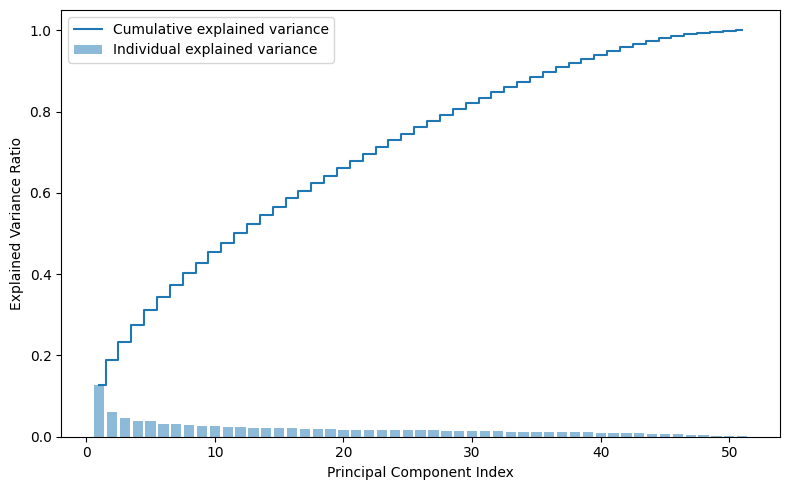

In [8]:
# Create a pipeline to standardize data and then apply PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

# Fit the pipeline to the data
X_pca = pipeline.fit_transform(X)

# The explained_variance_ratio_ gives us the variance contributed by each of the components
# We can use it to plot the cumulative variance explained by the components
explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
# Get the loadings (also called the components attribute of the PCA)
loadings = pipeline.named_steps['pca'].components_

# We're interested in the first 5 PCs
n_components = 5

# Create a DataFrame to store loadings for the first 5 PCs
# Each row will represent a principal component (PC), and each column will correspond to the original features
loadings_df = pd.DataFrame(loadings[:n_components], columns=X.columns)

# Transpose the DataFrame so that each row represents a feature, and each column represents a PC
loadings_df = loadings_df.T

# Now, each column in 'loadings_df' represents a PC, and you can look at the loadings for each feature
print(loadings_df)

                                         0         1         2         3         4
Age                              -0.164205 -0.434099  0.118681  0.056614  0.019271
BMI                               0.018508 -0.046665  0.154676 -0.077425 -0.122652
Sex                               0.061217  0.039259 -0.155291  0.083406  0.227215
Height                           -0.155410 -0.453209  0.106001  0.073327  0.073174
Weight                           -0.148166 -0.423757  0.162551  0.041249  0.095833
Length_of_Stay                    0.214174 -0.048916  0.215759  0.217567 -0.102556
Alvarado_Score                    0.315820 -0.166777 -0.126712 -0.216179  0.017122
Paedriatic_Appendicitis_Score     0.272851 -0.196484 -0.159891 -0.284102 -0.124499
Appendix_on_US                    0.050128 -0.058287 -0.346820  0.262164 -0.106659
Appendix_Diameter                 0.196372 -0.092661 -0.012828  0.172064  0.097611
Migratory_Pain                    0.047155 -0.164483 -0.152947 -0.100553 -0.201417
Lowe

This list shows the loadings for the first 10 principal components derived from the PCA. Each value represents the weight of the corresponding feature in this principal component. The principal components themselves are a linear combination of all the original features, weighted by these loading values. In general, the larger the absolute value of the loading, the more the feature contributes to the component. In the context of the data, this first principal component seems to be influenced the most by features like the Alvarado Score, WBC Count, Neutrophil Percentage, and Paediatric Appendicitis Score, among others, suggesting these features play a significant role in the variance this component represents.

**RANDOM FOREST**

Random Forest is an ensemble learning technique known for its high accuracy and robustness. It operates by constructing multiple decision trees during the training process and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. In our EDA, we employ Random Forest not only as a predictive model but also as a means to assess the importance of different features. By examining feature importances, we can discern which variables have the most significant impact on the predictive power of the model, which may guide us in feature selection and model simplification.

In [10]:
# Create a pipeline with a RandomForestClassifier with a specified number of estimators and a fixed random state for reproducibility that first scales the features then trains a RandomForest model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Random Forest classifier
])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9668874172185431


**FEATURE IMPORTANCE**

Feature importance scores provide insight into the predictive power of each feature in the model. Higher scores indicate a greater influence on the model's decision-making process. These scores are useful for selecting features, understanding data, and improving model interpretability. The numeric importance values represent the weight of each feature, with higher values indicating stronger predictive power.

In [11]:
# Calculate feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

                             Feature  Importance
9                  Appendix_Diameter    0.175657
8                     Appendix_on_US    0.118081
5                     Length_of_Stay    0.101271
17                         WBC_Count    0.055503
41       Surrounding_Tissue_Reaction    0.052401
18             Neutrophil_Percentage    0.047332
28                               CRP    0.043542
6                     Alvarado_Score    0.032803
19             Segmented_Neutrophils    0.029922
24                 Thrombocyte_Count    0.026819
31                       Peritonitis    0.022917
7      Paedriatic_Appendicitis_Score    0.022621
0                                Age    0.021915
16                  Body_Temperature    0.021488
21                         RBC_Count    0.021435
1                                BMI    0.021206
22                        Hemoglobin    0.021108
3                             Height    0.020511
4                             Weight    0.018484
23                  

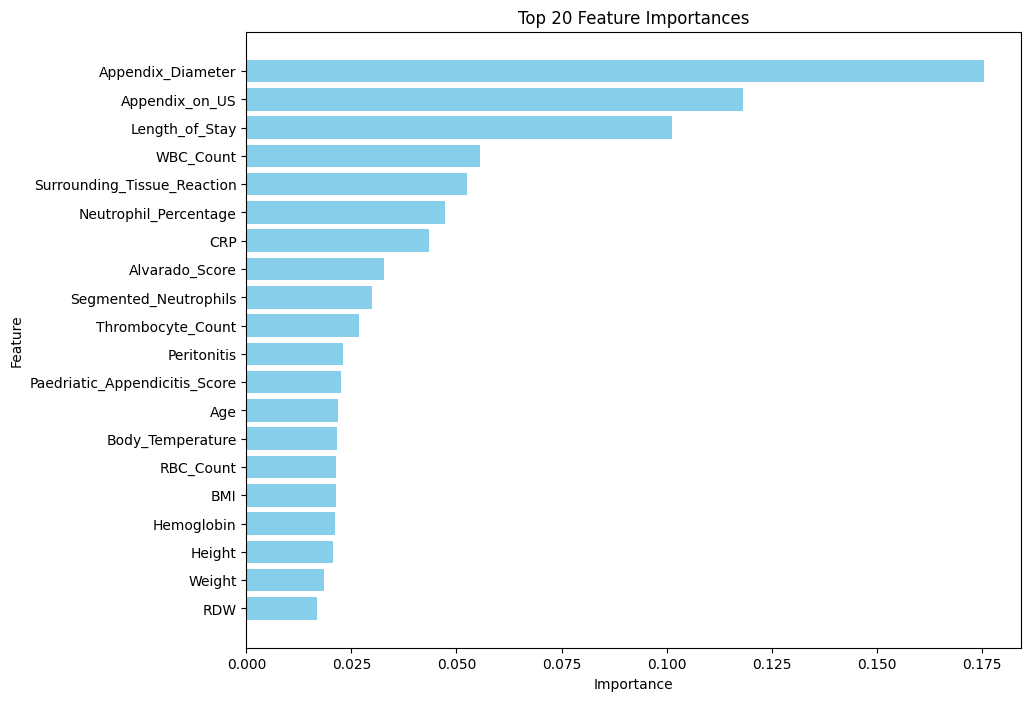

In [12]:
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20], color='skyblue')  # top 20 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # highest importance at the top
plt.show()

The bar plot displays the top 20 features ranked by their importance scores as determined by the model. Notably, 'Appendix_Diameter' and 'Appendix_on_US' emerge as the most impactful features.

**Feature Selection with LASSO or Elastic Net Introduction**

"LASSO (Least Absolute Shrinkage and Selection Operator) and Elastic Net are regularization techniques that not only prevent overfitting by penalizing complex models but also perform feature selection. LASSO does this by penalizing the absolute size of the regression coefficients, driving some to zero, effectively selecting a simpler model that does not include those features.

In [13]:
# Set up the pipeline
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(cv=5, random_state=42))
])

# Fit the pipeline and print selected features by Lasso
pipeline_lasso.fit(X, y)
selected_features_lasso = X.columns[(pipeline_lasso.named_steps['lasso_cv'].coef_ != 0)]
print('Selected features by LASSO:', selected_features_lasso)

Selected features by LASSO: Index(['BMI', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'WBC_Count', 'Neutrophil_Percentage',
       'Segmented_Neutrophils', 'Stool', 'Peritonitis', 'US_Performed', 'Target_Sign', 'Appendicolith', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Bowel_Wall_Thickening', 'Ileus', 'Enteritis', 'Gynecological_Findings'],
      dtype='object')


Elastic Net combines LASSO's L1 penalty with Ridge Regression's L2 penalty, balancing feature selection with coefficient shrinkage. Incorporating cross-validation, we can optimize the regularization strength to find the most predictive features while maintaining model simplicity.

In [14]:
# Set up the pipeline for ElasticNet with cross-validation
pipeline_elasticnet = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet_cv', ElasticNetCV(cv=5, random_state=42))
])

# Fit the pipeline and print selected features by ElasticNet
pipeline_elasticnet.fit(X, y)
selected_features_elasticnet = X.columns[(pipeline_elasticnet.named_steps['elasticnet_cv'].coef_ != 0)]
print('Selected features by ElasticNet:', selected_features_elasticnet)

Selected features by ElasticNet: Index(['BMI', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'WBC_Count', 'Neutrophil_Percentage',
       'Segmented_Neutrophils', 'Stool', 'Peritonitis', 'US_Performed', 'Target_Sign', 'Appendicolith', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Bowel_Wall_Thickening', 'Ileus', 'Enteritis', 'Gynecological_Findings'],
      dtype='object')


**Correlation with Target Variable**

To understand how the features correlate with the target variable, we can calculate the correlation coefficient for each feature with the target. This step can highlight which features have the strongest linear relationship with the target variable, guiding feature selection and offering insights into the structure of the model.

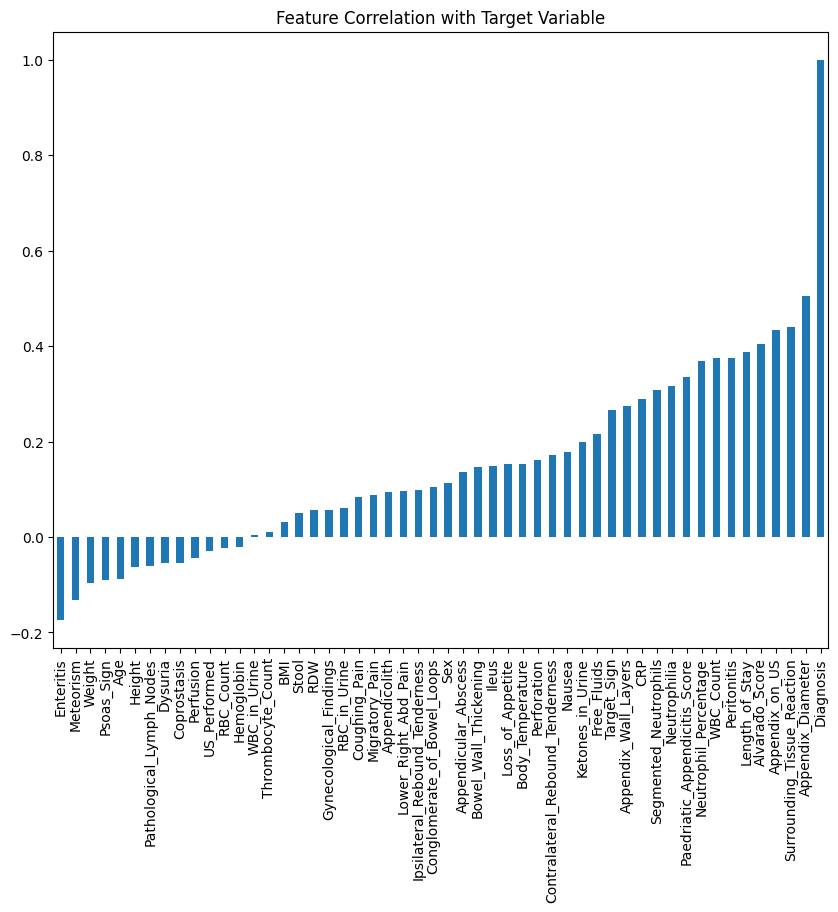

In [15]:
# Calculate the correlation of all features with the target variable
feature_target_corr = data.corrwith(data['Diagnosis'])

# Plot the correlations
plt.figure(figsize=(10, 8))
feature_target_corr.sort_values().plot(kind='bar')
plt.title('Feature Correlation with Target Variable')
plt.show()

Through this exploratory data analysis, we've comprehensively examined our dataset from multiple angles, starting with outlier detection to ensure the robustness of our findings. By analyzing feature correlations and applying PCA, we've gained insights into the underlying structure of the data, which helped identify key features and reduce dimensionality. The Random Forest model allowed us to understand feature importance from a predictive modeling perspective, while LASSO and Elastic Net helped refine our feature set further, ensuring that our models are both interpretable and efficient. Lastly, examining how features correlate with the target variable provided a direct link to potential predictive power, guiding our subsequent modeling efforts. This thorough EDA has set a solid foundation for building predictive models that are insightful, accurate, and relevant to our objectives.